### Identify SWOT Orbits

In [1]:
import sys
import imp
import json
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import HTML
tqdm.pandas()

In [2]:
def import_from_github(url: str):
    with requests.get(url) as response: 
        module = imp.new_module("swot")
        exec(response.text, module.__dict__)
        return module

swot = import_from_github("https://raw.githubusercontent.com/jjmcnelis/trusted-methods/main/py/swot.py")

#### Science

In [3]:
var = ['data_01_time', 
       'data_01_latitude', 
       'data_01_longitude', 
       'data_01_ku_ssha',   ]

In [4]:
def get_swot_nadir_granules_for_cycles(ShortName:   str, 
                                       start_cycle: int=1, 
                                       end_cycle:   int=1, 
                                       variables:   list=var):

    # Get the unique collection 'concept-id' for the target collection
    ccid = requests.get(url=f"https://cmr.earthdata.nasa.gov/search/collections.umm_json",
                        params={'ShortName': ShortName}).json() \
                   .get("items")[0].get("meta").get("concept-id")

    # Make a data frame of cycles and pull down granule metadata from CMR for each one in a series
    cycles = pd.DataFrame({'cycle': list(range(start_cycle, end_cycle+1))})

    cycles['granules'] = cycles.cycle.progress_apply(lambda x: swot.nadir_query_example(ccid, cycle=x))
    
    # Melt the cycles table into a tall table of granules, one per row
    df          = pd.concat(cycles.granules.tolist())[["Granule UR"]].set_index("Granule UR")
    df['file']  = df.index.to_series()
    df['dap']   = df.apply(lambda x: f"https://opendap.earthdata.nasa.gov/collections/{ccid}/granules/{x.file}", axis=1)
    df['url']   = df.dap.apply(lambda x: f"{x}.nc4?{','.join(var)}")
    df['path']  = swot.download_all(df.url.tolist())
    df['cycle'] = df.file.apply(lambda x: x.split("_")[2][4:])
    df['pass']  = df.file.apply(lambda x: x.split("_")[3])
    df['start'] = df.file.apply(lambda x: "T".join(x.split("_")[4:6])).apply(lambda x: swot.dt.strptime(x,"%Y%m%dT%H%M%S"))
    df['end']   = df.file.apply(lambda x: "T".join(x.split("_")[6:8])).apply(lambda x: swot.dt.strptime(x,"%Y%m%dT%H%M%S"))

    return df

In [5]:
df = get_swot_nadir_granules_for_cycles("SWOT_SIMULATED_L2_NADIR_SSH_ECCO_LLC4320_SCIENCE_V1", 
                                        start_cycle=1, 
                                        end_cycle=4)

100%|██████████| 2336/2336 [00:00<00:00, 373153.60it/s]


In [6]:
df.iloc[0]

file     SWOT_GPR_2PTP001_001_20111113_000000_20111113_...
dap      https://opendap.earthdata.nasa.gov/collections...
url      https://opendap.earthdata.nasa.gov/collections...
path     data/SWOT_GPR_2PTP001_001_20111113_000000_2011...
cycle                                                  001
pass                                                   001
start                                  2011-11-13 00:00:00
end                                    2011-11-13 00:51:26
Name: SWOT_GPR_2PTP001_001_20111113_000000_20111113_005126, dtype: object

In [7]:
c1 = swot.xr.open_mfdataset(sorted(df[df.cycle=='001'].path.tolist()), combine='by_coords')

print(c1)

<xarray.Dataset>
Dimensions:            (data_01_time: 1772883)
Coordinates:
  * data_01_time       (data_01_time) datetime64[ns] 2011-11-13 ... 2011-12-0...
Data variables:
    data_01_longitude  (data_01_time) float64 dask.array<chunksize=(3036,), meta=np.ndarray>
    data_01_latitude   (data_01_time) float64 dask.array<chunksize=(3036,), meta=np.ndarray>
    data_01_ku_ssha    (data_01_time) float32 dask.array<chunksize=(3036,), meta=np.ndarray>
Attributes: (12/22)
    Conventions:             CF-1.7
    title:                   GDR - Reduced dataset
    source:                  Simulate product
    contact:                 CNES aviso@altimetry.fr, JPL podaac@podaac.jpl.n...
    reference_document:      SWOT Nadir Altimeter Products Handbook, SALP-MU-...
    mission_name:            SWOT
    ...                      ...
    first_meas_time:         2011-11-13T00:00:00Z
    last_meas_time:          2011-11-13T00:51:26.031671Z
    ellipsoid_axis:          6378137.0
    ellipsoid_flatt

Text(0.5, 1.0, 'ssha for cycle 1')

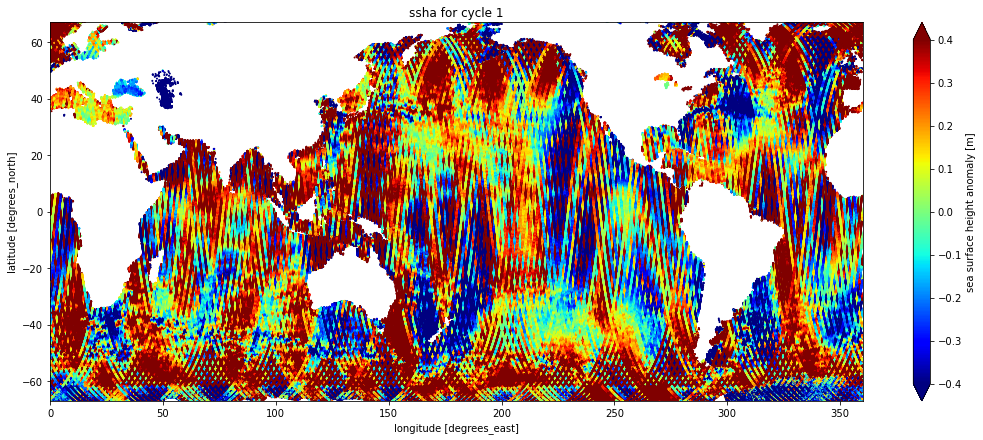

In [8]:
import matplotlib.pyplot as plt

c1.plot.scatter(y="data_01_latitude", x="data_01_longitude", hue="data_01_ku_ssha", 
                vmin=-0.4, vmax=0.4, cmap="jet",
                aspect=2.5, size=6, s=1, )

plt.ylim(-67.,  67.)
plt.xlim(  0., 360.)
plt.tight_layout()
plt.title(f"ssha for cycle 1")